# Libraries

In [129]:
import spacy
import random
import string
import regex as re
import numpy as np
import pandas as pd
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.stem import PorterStemmer
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from tensorflow.keras import optimizers
from nltk.tokenize import word_tokenize
from nltk.stem import LancasterStemmer, PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords


import tensorflow as tf
from keras.utils import plot_model, to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau


# Data

In [79]:
data = pd.read_csv('twitter_training.csv')
val_data = pd.read_csv('twitter_validation.csv')
data.head(10)

,2401,Borderlands,Positive,"im getting on borderlands and i will murder you all ,"
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...
5,2402,Borderlands,Positive,So I spent a few hours making something for fu...
6,2402,Borderlands,Positive,So I spent a couple of hours doing something f...
7,2402,Borderlands,Positive,So I spent a few hours doing something for fun...
8,2402,Borderlands,Positive,So I spent a few hours making something for fu...
9,2402,Borderlands,Positive,2010 So I spent a few hours making something f...


In [80]:
data.rename(columns={
    '2401': 'Index',
    'Borderlands': 'Land',
    'Positive': 'Category',
    'im getting on borderlands and i will murder you all ,': 'Text'
}, inplace=True)

val_data.rename(columns={
    '3364': 'Index',
    'Facebook': 'Land',
    'Irrelevant': 'Category',
    'I mentioned on Facebook that I was struggling for motivation to go for a run the other day, which has been translated by Tom’s great auntie as ‘Hayley can’t get out of bed’ and told to his grandma, who now thinks I’m a lazy, terrible person 🤣': 'Text'
}, inplace=True)

val_data

,Index,Land,Category,Text
0,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
1,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
2,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
3,4433,Google,Neutral,Now the President is slapping Americans in the...
4,6273,FIFA,Negative,Hi @EAHelp I’ve had Madeleine McCann in my cel...
...,...,...,...,...
994,4891,GrandTheftAuto(GTA),Irrelevant,⭐️ Toronto is the arts and culture capital of ...
995,4359,CS-GO,Irrelevant,tHIS IS ACTUALLY A GOOD MOVE TOT BRING MORE VI...
996,2652,Borderlands,Positive,Today sucked so it’s time to drink wine n play...
997,8069,Microsoft,Positive,Bought a fraction of Microsoft today. Small wins.


## Summary of data

In [81]:
print(f'The shape of the dataset is: {data.shape}\n')
print(f'The data columns are:\n {data.columns}\n')
print(f'The data types are:\n{data.dtypes}')

The shape of the dataset is: (74681, 4)

The data columns are:
 Index(['Index', 'Land', 'Category', 'Text'], dtype='object')

The data types are:
Index        int64
Land        object
Category    object
Text        object
dtype: object


In [82]:
data.describe(include='all')

,Index,Land,Category,Text
count,74681.000000,74681,74681,73995
unique,NaN,32,4,69490
top,NaN,TomClancysRainbowSix,Negative,
freq,NaN,2400,22542,172
mean,6432.640149,NaN,NaN,NaN
std,3740.423819,NaN,NaN,NaN
min,1.000000,NaN,NaN,NaN
25%,3195.000000,NaN,NaN,NaN
50%,6422.000000,NaN,NaN,NaN
75%,9601.000000,NaN,NaN,NaN


# Exploratory Data Analysis

In [83]:
def show_details(data):
    missed_values = data.isnull().sum()
    missed_values_percent = (data.isnull().sum()/len(data))
    duplicated_values = data.duplicated().sum()
    duplicated_values_percent = (data.duplicated().sum()/len(data))
    
    info_frame = pd.DataFrame({
        'Missed values': missed_values,
        'Missed values %': missed_values_percent,
        'Duplicated values': duplicated_values,
        'Duplicated values %': duplicated_values_percent
    })
    return info_frame.T
show_details(data)

,Index,Land,Category,Text
Missed values,0.000000,0.000000,0.000000,686.000000
Missed values %,0.000000,0.000000,0.000000,0.009186
Duplicated values,2700.000000,2700.000000,2700.000000,2700.000000
Duplicated values %,0.036154,0.036154,0.036154,0.036154


## Land

C:\Users\user\AppData\Local\Temp\ipykernel_28744\3846019374.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  bar = sns.barplot(x = lands.values[:10], y = lands.index[:10], palette='pastel', edgecolor = 'black')


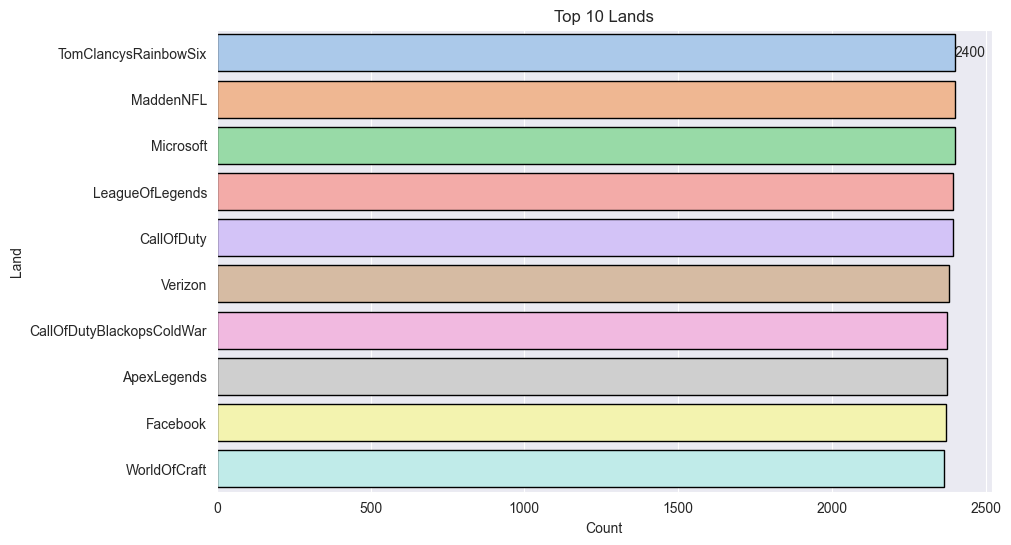

In [84]:
sns.set_style('darkgrid')
lands = data.Land.value_counts()
plt.figure(figsize = (10, 6))
bar = sns.barplot(x = lands.values[:10], y = lands.index[:10], palette='pastel', edgecolor = 'black')
bar.bar_label(bar.containers[0])
plt.title('Top 10 Lands')
plt.xlabel('Count')
plt.ylabel('Land')
plt.show()

## Category

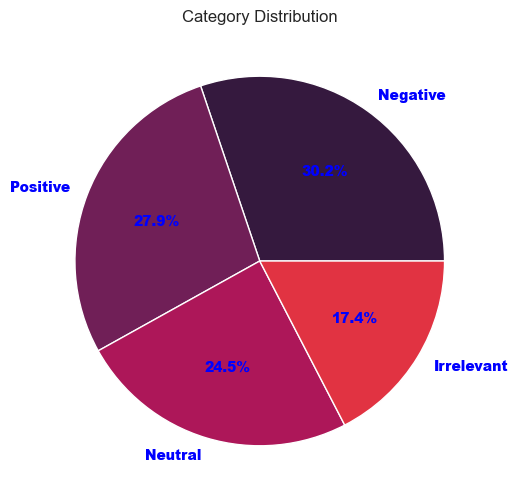

In [85]:
cat = data.Category.value_counts()
plt.figure(figsize = (6, 6))
plt.pie(x = cat.values, labels=cat.keys(), autopct = '%1.1f%%',
        textprops={'fontsize': 10, 'fontweight': 'black', 'color': 'blue'}, colors=sns.color_palette('rocket'))
plt.title('Category Distribution')
plt.show()

Distribution Category accross Land

In [86]:
pd.crosstab(data.Category , data.Land).T.style.background_gradient( subset=['Negative'],cmap='Reds')\
.background_gradient(subset=['Positive'] , cmap='Greens')\
.background_gradient(subset=['Irrelevant'] , cmap='Blues')

Category,Irrelevant,Negative,Neutral,Positive
Land,,,,
Amazon,192,576,1236,312
ApexLegends,192,600,942,642
AssassinsCreed,264,378,156,1446
Battlefield,918,474,360,594
Borderlands,240,426,600,1019
CS-GO,636,348,552,768
CallOfDuty,672,894,378,450
CallOfDutyBlackopsColdWar,576,576,360,864
Cyberpunk2077,480,390,468,966


# Preprocessing

In [87]:
def clean_emoji(tx):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols 
                           u"\U0001F680-\U0001F6FF"  # transport 
                           u"\U0001F1E0-\U0001F1FF"  # flags 
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', tx)


def text_cleaner(tx):
    text = re.sub(r"won\'t", "would not", tx)
    text = re.sub(r"im", "i am", tx)
    text = re.sub(r"Im", "I am", tx)
    text = re.sub(r"can\'t", "can not", text)
    text = re.sub(r"don\'t", "do not", text)
    text = re.sub(r"shouldn\'t", "should not", text)
    text = re.sub(r"needn\'t", "need not", text)
    text = re.sub(r"hasn\'t", "has not", text)
    text = re.sub(r"haven\'t", "have not", text)
    text = re.sub(r"weren\'t", "were not", text)
    text = re.sub(r"mightn\'t", "might not", text)
    text = re.sub(r"didn\'t", "did not", text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub(r'[^a-zA-Z0-9\!\?\.\@]',' ' , text)
    text = re.sub(r'[!]+' , '!' , text)
    text = re.sub(r'[?]+' , '?' , text)
    text = re.sub(r'[.]+' , '.' , text)
    text = re.sub(r'[@]+' , '@' , text)
    text = re.sub(r'unk' , ' ' , text)
    text = re.sub('\n', '', text)
    text = text.lower()
    text = re.sub(r'[ ]+' , ' ' , text)
    
    return text

In [88]:
random.seed(99)
text = text_cleaner(random.choice(data['Text']))
text = clean_emoji(text)
text

'ghost of tsushima is now graphically the best open world. red dead redemption 2 is one second ahead.'

## POS Tagging

In [89]:
nlp = spacy.load('en_core_web_sm')
doc = nlp(text)
for token in doc:
    print(f'{token} --> {token.lemma_}')

ghost --> ghost
of --> of
tsushima --> tsushima
is --> be
now --> now
graphically --> graphically
the --> the
best --> well
open --> open
world --> world
. --> .
red --> red
dead --> dead
redemption --> redemption
2 --> 2
is --> be
one --> one
second --> second
ahead --> ahead
. --> .


## NER (Named Entity Recognition)

In [90]:
doc = nlp(text)
for ent in doc.noun_chunks:
    print(f'{ent} -> {ent.label_}')

ghost -> NP
tsushima -> NP
the best open world -> NP
red dead redemption -> NP


## Tokenize Text

In [91]:
def process_text(text):
    # Initialize tools
    if pd.isnull(text):
        return []
    
    STEMMER = LancasterStemmer()
    LEMMATIZER = WordNetLemmatizer()
    STOP_WORDS = stopwords.words('english')
    PUNCTUATION = string.punctuation

    # Apply emoji and text cleaning
    text = clean_emoji(text)
    text = text_cleaner(text)
    
    # Tokenization, stopword removal, stemming, and lemmatization
    words = word_tokenize(text)
    words = [word for word in words if word not in PUNCTUATION and word not in STOP_WORDS and word.isalpha()]
    words = [STEMMER.stem(word) for word in words]
    words = [LEMMATIZER.lemmatize(word) for word in words]
    
    return ' '.join(words)
data['Text'] = data['Text'].apply(process_text)
val_data['Text'] = val_data['Text'].apply(process_text)
val_data

,Index,Land,Category,Text
0,352,Amazon,Neutral,bbc new amazon bos jeff bezo reject claim comp...
1,8312,Microsoft,Negative,microsoft pay word funct poor samsung chromebook
2,4371,CS-GO,Negative,csgo matchmak ful closet hack tru aw gam
3,4433,Google,Neutral,presid slap am fac real commit unlaw act acqui...
4,6273,FIFA,Negative,hi eahelp madelein mccann cell past year littl...
...,...,...,...,...
994,4891,GrandTheftAuto(GTA),Irrelevant,toronto art cult capit canad wond want start p...
995,4359,CS-GO,Irrelevant,act good mov tot bring view on peopl got hook ...
996,2652,Borderlands,Positive,today suck tim drink win n play borderland sun...
997,8069,Microsoft,Positive,bought fract microsoft today smal win


## Wordcloud

Positive Text

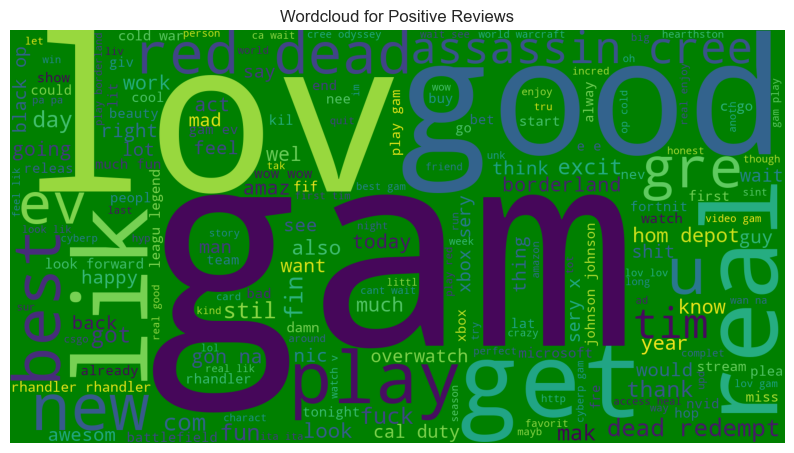

In [92]:
positive_reviews = data[data['Category'] == 'Positive']['Text']
pos = ' '.join(map(str, positive_reviews))
pos_wordcloud = WordCloud(width=1500, height=800,
                          background_color='green',
                          stopwords=stopwords.words('english'),
                          min_font_size = 15).generate(pos)
plt.figure(figsize = (10, 10))
plt.imshow(pos_wordcloud)
plt.title('Wordcloud for Positive Reviews')
plt.axis('off')
plt.show()

Negative Text

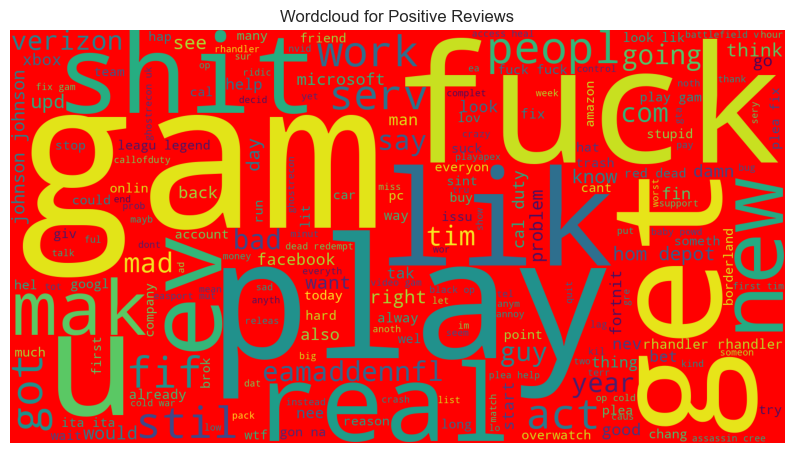

In [93]:
positive_reviews = data[data['Category'] == 'Negative']['Text']
pos = ' '.join(map(str, positive_reviews))
pos_wordcloud = WordCloud(width=1500, height=800,
                          background_color='red',
                          stopwords=stopwords.words('english'),
                          min_font_size = 15).generate(pos)
plt.figure(figsize = (10, 10))
plt.imshow(pos_wordcloud)
plt.title('Wordcloud for Positive Reviews')
plt.axis('off')
plt.show()

Irrelevant

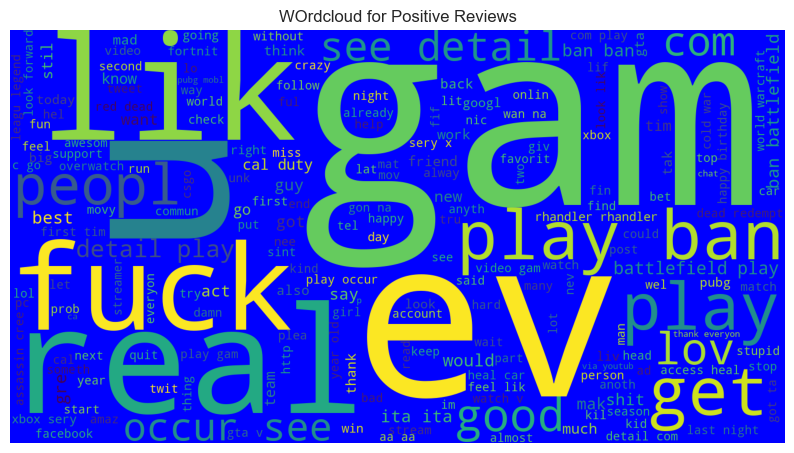

In [94]:
positive_reviews = data[data['Category'] == 'Irrelevant']['Text']
pos = ' '.join(map(str, positive_reviews))
pos_wordcloud = WordCloud(width=1500, height=800,
                          background_color='blue',
                          stopwords=stopwords.words('english'),
                          min_font_size = 15).generate(pos)
plt.figure(figsize = (10, 10))
plt.imshow(pos_wordcloud)
plt.title('WOrdcloud for Positive Reviews')
plt.axis('off')
plt.show()

Neutral

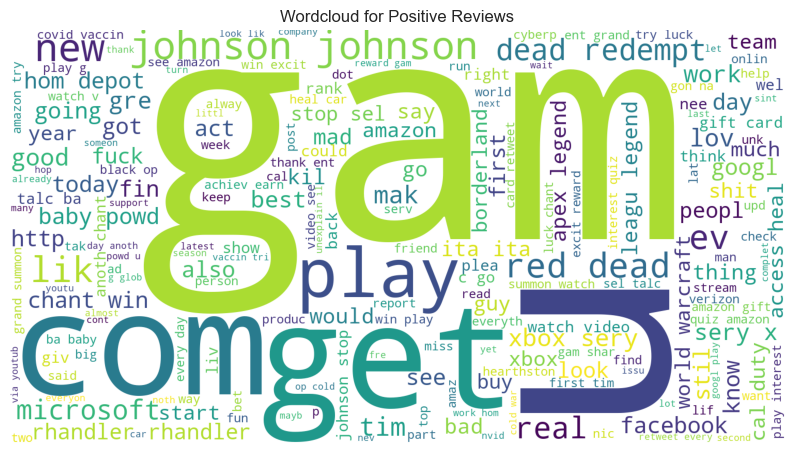

In [95]:
positive_reviews = data[data['Category'] == 'Neutral']['Text']
pos = ' '.join(map(str, positive_reviews))
pos_wordcloud = WordCloud(width=1500, height=800,
                          background_color='white',
                          stopwords=stopwords.words('english'),
                          min_font_size = 15).generate(pos)
plt.figure(figsize = (10, 10))
plt.imshow(pos_wordcloud)
plt.title('Wordcloud for Positive Reviews')
plt.axis('off')
plt.show()

# Modeling

## Load Glove

In [96]:
def load_glove_embeddings(file_path):
    embeddings_index = {}
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    return embeddings_index
embeddings_index = load_glove_embeddings(r"C:\Users\user\Documents\Datasets\Sentiment analysis\glove.twitter.27B.100d.txt")

## Embedding Matrix

In [97]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data['Text'])

#Convert into sequences
X_train_sequences = tokenizer.texts_to_sequences(data['Text'])
X_val_sequences = tokenizer.texts_to_sequences(val_data['Text'])

max_length = max(max(len(seq) for seq in X_train_sequences), max(len(seq) for seq in X_val_sequences))

#Pad sequences to ensure uniform input length
X_train_padded = pad_sequences(X_train_sequences, maxlen=max_length, padding='post')
X_val_padded = pad_sequences(X_val_sequences, maxlen=max_length, padding='post')

In [98]:
# Get vocabulary size and embedding dimension
vocab_size = len(tokenizer.word_index) + 1  # Add 1 for padding token
embedding_dim = 100  # Dimensionality of GloVe embeddings

# Create the embedding matrix
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

## Splitting Training and Test dataset

In [124]:
encoder = OneHotEncoder()
y = encoder.fit_transform(np.array(data['Category']).reshape(-1,1)).toarray()
y_val = encoder.fit_transform(np.array(val_data['Category']).reshape(-1,1)).toarray()

X = X_train_padded
X_val = X_val_padded
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [131]:
input_size = np.max(X_train_padded) + 1

# Traning

## Model Checkpoint

In [100]:
# Model CheckPoint
checkpoint_cb = ModelCheckpoint('MyModel.keras', save_best_only=True)

# Early Stopping
earlystop_cb = EarlyStopping(patience=10, restore_best_weights=True)

# ReduceLRonPlateau
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.5, patience = 3, min_lr = 1e-6)

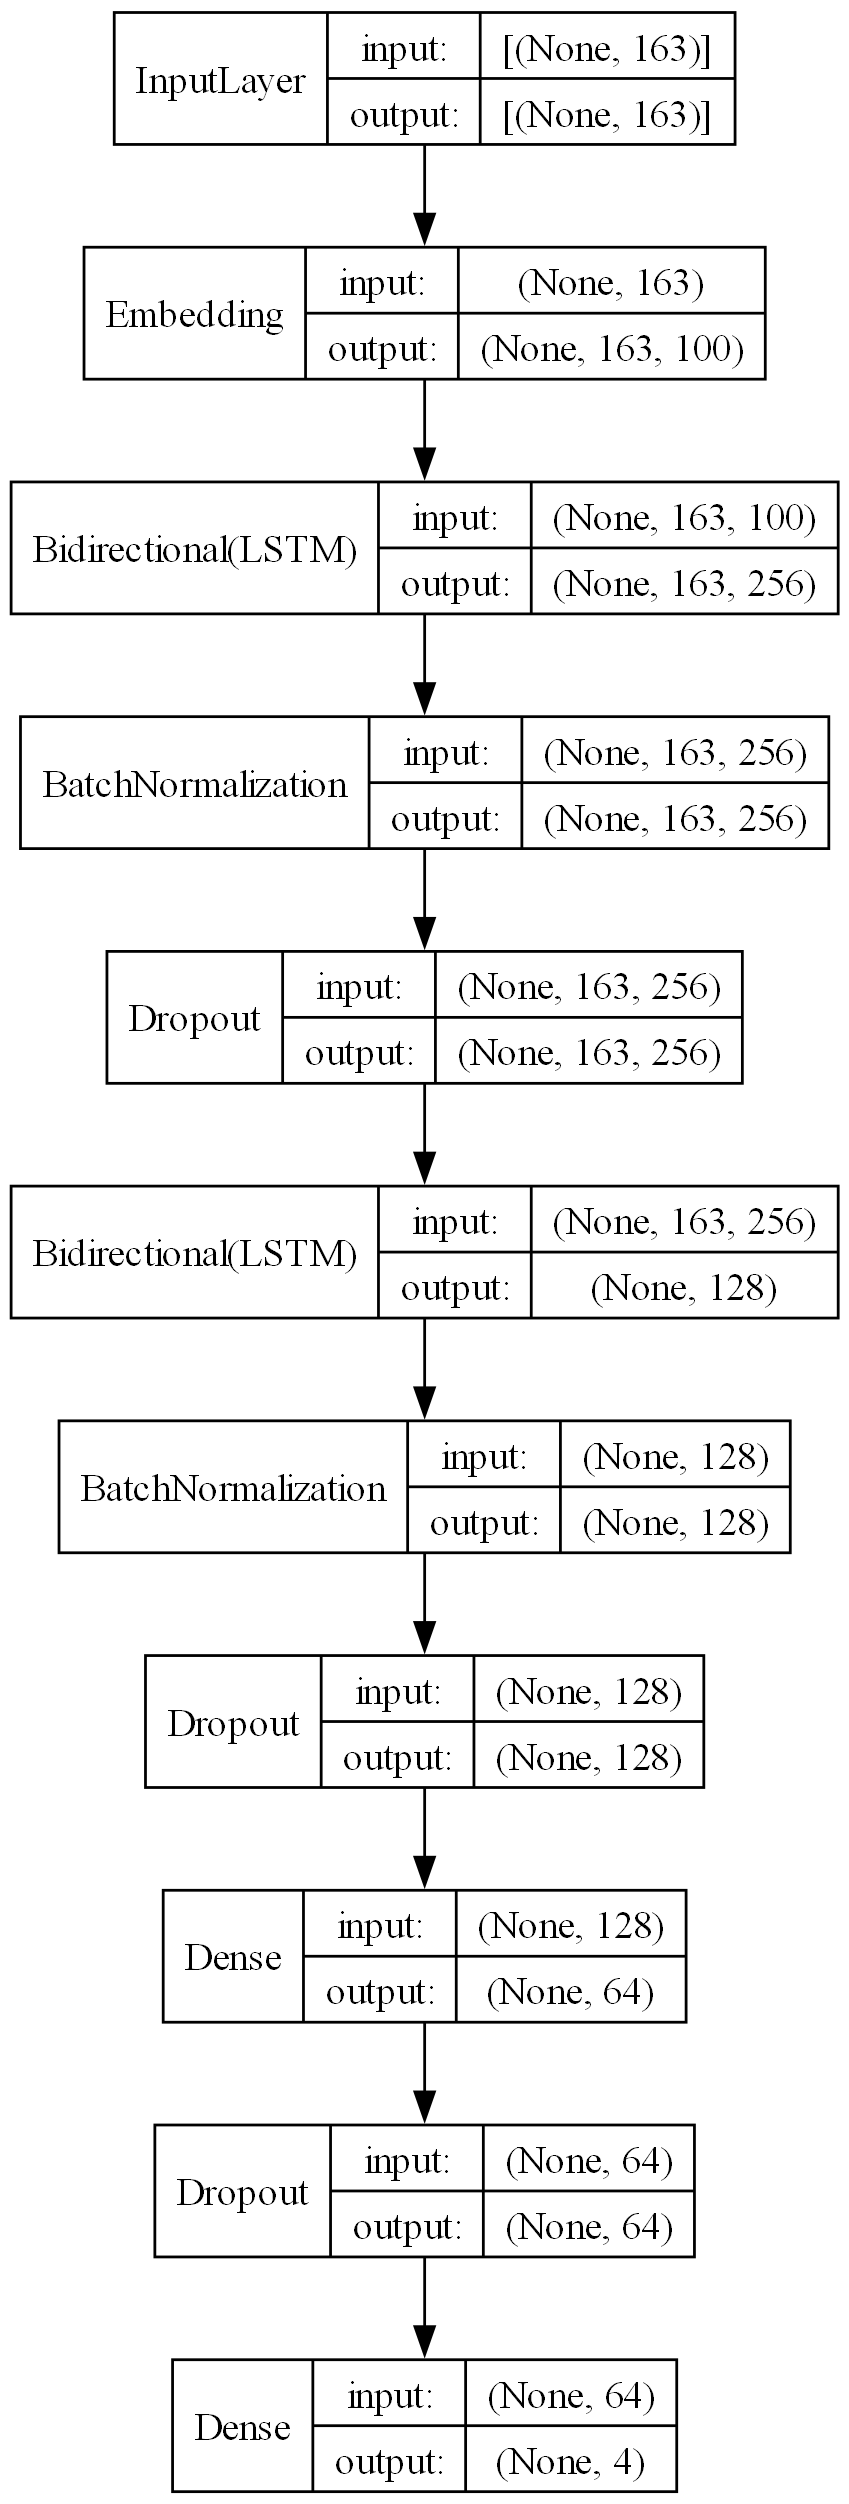

In [137]:
model = Sequential()

# Add an embedding layer 
model.add(Embedding(input_dim=vocab_size, 
                    output_dim=embedding_dim, 
                    input_length=max_length, 
                    weights=[embedding_matrix], 
                    trainable=False)) 

# Add a bidirectional LSTM layer with 128 units
model.add(Bidirectional(LSTM(128, kernel_regularizer=l2(0.1), return_sequences=True, recurrent_regularizer=l2(0.1))))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Add another LSTM layer
model.add(Bidirectional(LSTM(64, kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01))))
# Add batch normalization layer
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Add a dense layer with 64 units and ReLU activation
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))

# Add dropout regularization
model.add(Dropout(0.5))

# Add the output layer with 5 units for 5 labels and softmax activation
model.add(Dense(4, activation='softmax'))
plot_model(model, show_shapes=True, show_layer_names=False, dpi = 200)

In [138]:
model.compile(optimizer = optimizers.Adam(learning_rate=0.001),
               loss = 'categorical_crossentropy',
               metrics = ['accuracy'])

history = model.fit(
    X_train,
    y_train,
    epochs = 50,
    batch_size = 32,
    validation_data = (X_val, y_val),
    callbacks = [checkpoint_cb, earlystop_cb, reduce_lr]
)

Epoch 1/50
1867/1867 [==============================] - 122s 63ms/step - loss: 3.8895 - accuracy: 0.4043 - val_loss: 1.3342 - val_accuracy: 0.4575 - lr: 0.0010
Epoch 2/50
1867/1867 [==============================] - 117s 63ms/step - loss: 1.3362 - accuracy: 0.4497 - val_loss: 1.3571 - val_accuracy: 0.4124 - lr: 0.0010
Epoch 3/50
1867/1867 [==============================] - 117s 63ms/step - loss: 1.3291 - accuracy: 0.4556 - val_loss: 1.2929 - val_accuracy: 0.4725 - lr: 0.0010
Epoch 4/50
1867/1867 [==============================] - 118s 63ms/step - loss: 1.3242 - accuracy: 0.4587 - val_loss: 1.2629 - val_accuracy: 0.4755 - lr: 0.0010
Epoch 5/50
1867/1867 [==============================] - 117s 63ms/step - loss: 1.3083 - accuracy: 0.4637 - val_loss: 1.3089 - val_accuracy: 0.4735 - lr: 0.0010
Epoch 6/50
1867/1867 [==============================] - 118s 63ms/step - loss: 1.3026 - accuracy: 0.4663 - val_loss: 1.2808 - val_accuracy: 0.4705 - lr: 0.0010
Epoch 7/50
1867/1867 [==================

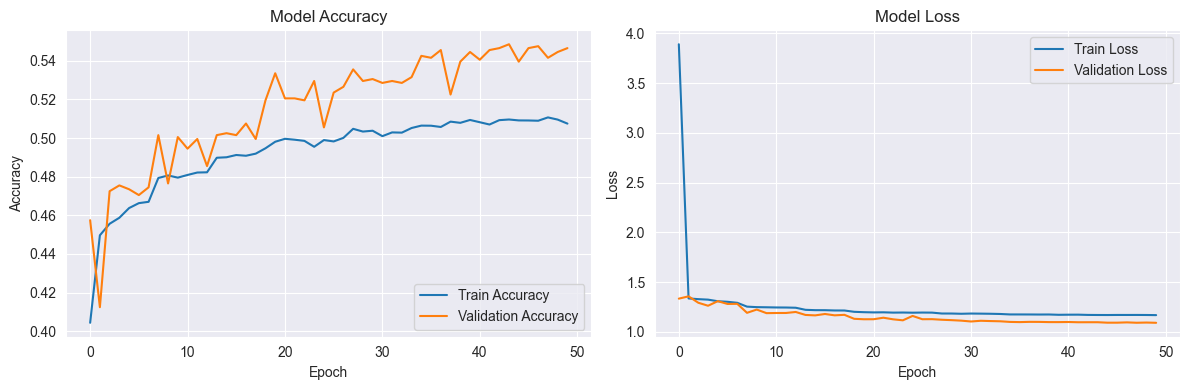

In [139]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()